# **Preprocess Data and Create Labels and Features**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import os
import cv2 as cv
import mediapipe as mp
from matplotlib import pyplot as plt
from mediapipe.python.solutions.pose import PoseLandmark

In [60]:
DATA_PATH = os.path.join('My_Datasets')

# sementara class berapa tidak digunakan
# sementara class terimakasih dan kamu ditiadakan (testing)
# kamu dan siapa bertabrakan
# terimakasih dan standby bertabrakan
# sementara siapa ditiadakan

actions = np.array(["maaf",
                    "tolong",
                    "nama",
                     "saya",
                     "siapa",
                       "rumah", 
                       "start",
                         "standby",
                           "delete",
                             ])

no_sequences = 30

sequence_length = 30

In [41]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'maaf': 0,
 'tolong': 1,
 'nama': 2,
 'saya': 3,
 'rumah': 4,
 'start': 5,
 'standby': 6,
 'delete': 7,
 'dimana': 8,
 'translate': 9}

In [42]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}-norm.npy".format(frame_num)))
            
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

np.array(sequences).shape

(300, 30, 108)

In [44]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(210, 30, 108)
(90, 30, 108)
(210, 10)
(90, 10)


# **Build and Train LSTM Neural Network**

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

In [46]:
checkpoint = ModelCheckpoint('test.h5', monitor='categorical_accuracy', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False,save_freq='epoch')

In [58]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=64, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))

# model.summary()

model = Sequential()

model.add(TimeDistributed(Dense(units=128, activation='tanh'), input_shape=(30, 108)))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_18 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                      

In [212]:
# model = Sequential()

# model.add(TimeDistributed(Dense(units=256, activation='tanh'), input_shape=(30, 108)))
# model.add(LSTM(128, return_sequences=False, activation='tanh', input_shape=(30,108)))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [213]:
# COMPLEX MODEL -> EXPERIMENTAL
# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))

In [214]:
# COMPLEX MODEL 2

# model = Sequential()

# model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(30,108)))
# model.add(LSTM(64, return_sequences=True, activation='tanh'))
# model.add(LSTM(32, return_sequences=False, activation='tanh'))
# model.add(Dropout(0.5))
# model.add(Dense(actions.shape[0], activation='softmax'))

Epoch 1/20
6/7 [========================>.....] - ETA: 0s - loss: 2.1021 - categorical_accuracy: 0.2708
Epoch 1: categorical_accuracy did not improve from 0.97143
7/7 [==============================] - 4s 194ms/step - loss: 2.0926 - categorical_accuracy: 0.2810 - val_loss: 1.8497 - val_categorical_accuracy: 0.5333
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.6802 - categorical_accuracy: 0.4667
Epoch 2: categorical_accuracy did not improve from 0.97143
7/7 [==============================] - 0s 37ms/step - loss: 1.6802 - categorical_accuracy: 0.4667 - val_loss: 1.5003 - val_categorical_accuracy: 0.6111
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.3460 - categorical_accuracy: 0.6000
Epoch 3: categorical_accuracy did not improve from 0.97143
7/7 [==============================] - 0s 36ms/step - loss: 1.3460 - categorical_accuracy: 0.6000 - val_loss: 1.2117 - val_categorical_accuracy: 0.7778
Epoch 4/20
7/7 [==============================] - ETA:

c:\Users\krisn\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 15: categorical_accuracy did not improve from 0.98571
7/7 [==============================] - 0s 37ms/step - loss: 0.2029 - categorical_accuracy: 0.9571 - val_loss: 0.2926 - val_categorical_accuracy: 0.9667
Epoch 16/20
7/7 [==============================] - ETA: 0s - loss: 0.1304 - categorical_accuracy: 0.9810
Epoch 16: categorical_accuracy did not improve from 0.98571
7/7 [==============================] - 0s 37ms/step - loss: 0.1304 - categorical_accuracy: 0.9810 - val_loss: 0.3092 - val_categorical_accuracy: 0.9667
Epoch 17/20
7/7 [==============================] - ETA: 0s - loss: 0.1362 - categorical_accuracy: 0.9905
Epoch 17: categorical_accuracy improved from 0.98571 to 0.99048, saving model to test.h5
7/7 [==============================] - 0s 40ms/step - loss: 0.1362 - categorical_accuracy: 0.9905 - val_loss: 0.2942 - val_categorical_accuracy: 0.9556
Epoch 18/20
7/7 [==============================] - ETA: 0s - loss: 0.0986 - categorical_accuracy: 0.9952
Epoch 18: categoric

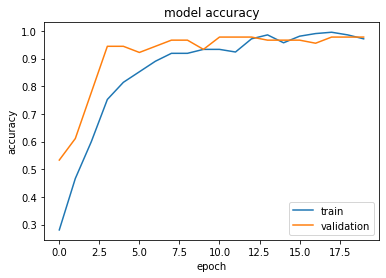

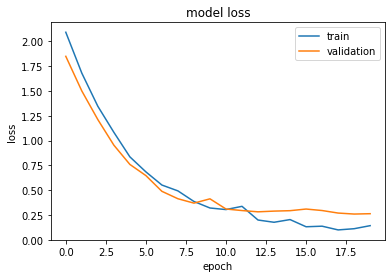

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 30, 128)           13952     
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dropout_18 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                      

In [59]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
train_model = model.fit(X_train, y_train, epochs=20, callbacks=[checkpoint], validation_data=(X_test, y_test))

plt.plot(train_model.history['categorical_accuracy'])
plt.plot(train_model.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
    
model.summary()

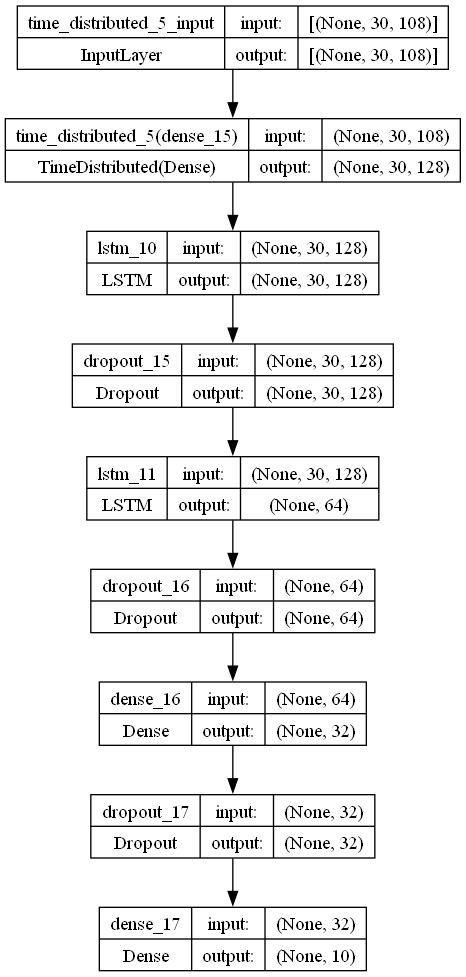

In [49]:
plot_model(model, to_file="model1.png", show_shapes=True)

# **Save Weights**

In [50]:
model_path = 'model-bimbingan7v4_2.h5'

model.save(model_path)
model.load_weights(model_path)

# **Evaluation using Confusion Matrix and Accuracy**

In [51]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

In [52]:
yhat = model.predict(X_test)

3/3 [==============================] - 1s 11ms/step


In [53]:
print(actions[np.argmax(yhat[2])])
print(actions[np.argmax(y_test[2])])

start
start


In [54]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [55]:
mcm = multilabel_confusion_matrix(ytrue, yhat)
print(mcm)

[[[79  0]
  [ 0 11]]

 [[82  0]
  [ 0  8]]

 [[78  0]
  [ 0 12]]

 [[78  0]
  [ 0 12]]

 [[85  0]
  [ 0  5]]

 [[80  2]
  [ 0  8]]

 [[82  0]
  [ 2  6]]

 [[76  0]
  [ 0 14]]

 [[86  0]
  [ 0  4]]

 [[82  0]
  [ 0  8]]]


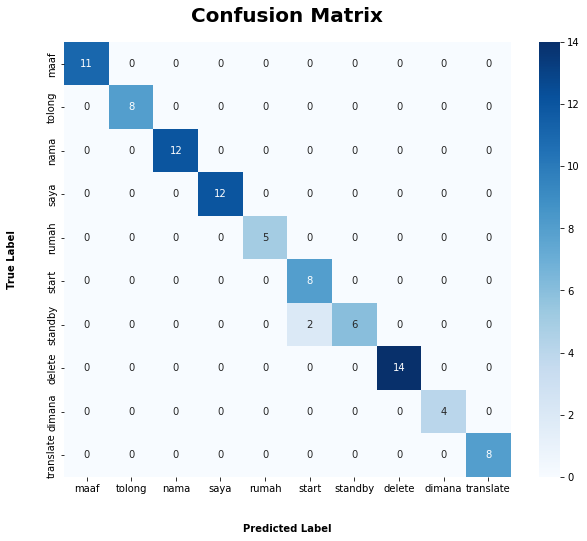

In [56]:
ytrue = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(ytrue, yhat)

plt.figure(figsize=(10, 8))
heatMap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)

heatMap.set_xlabel('Predicted Label', labelpad=30, weight='bold')
heatMap.set_ylabel('True Label', labelpad=30, weight='bold')

heatMap.set_title('Confusion Matrix', pad=20, weight='bold', fontsize=20)
plt.show()

In [31]:
from sklearn.metrics import classification_report

# Assuming ytrue and yhat are the true and predicted labels, respectively
report = classification_report(ytrue, yhat, target_names=actions)
print(report)

              precision    recall  f1-score   support

        maaf       1.00      1.00      1.00        11
      tolong       1.00      1.00      1.00         8
        nama       1.00      1.00      1.00        12
        saya       1.00      1.00      1.00        12
       rumah       1.00      1.00      1.00         5
       start       1.00      1.00      1.00         8
     standby       1.00      0.75      0.86         8
      delete       1.00      1.00      1.00        14
      dimana       0.67      1.00      0.80         4
   translate       1.00      1.00      1.00         8

    accuracy                           0.98        90
   macro avg       0.97      0.97      0.97        90
weighted avg       0.99      0.98      0.98        90



In [32]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming ytrue and yhat are the true and predicted labels, respectively
metrics = precision_recall_fscore_support(ytrue, yhat)

precision_per_class = metrics[0]
recall_per_class = metrics[1]
f1_score_per_class = metrics[2]

# Print metrics for each class
for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[i]}")
    print(f"Recall: {recall_per_class[i]}")
    print(f"F1 Score: {f1_score_per_class[i]}\n")

# For accuracy per class, you would need to calculate it manually:
accuracy_per_class = [(conf_matrix[i, i] / np.sum(conf_matrix[:, i])) for i in range(len(actions))]

for i, class_name in enumerate(actions):
    print(f"Class: {class_name}")
    print(f"Accuracy: {accuracy_per_class[i]}\n")

Class: maaf
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: tolong
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: nama
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: saya
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: rumah
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: start
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: standby
Precision: 1.0
Recall: 0.75
F1 Score: 0.8571428571428571

Class: delete
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: dimana
Precision: 0.6666666666666666
Recall: 1.0
F1 Score: 0.8

Class: translate
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Class: maaf
Accuracy: 1.0

Class: tolong
Accuracy: 1.0

Class: nama
Accuracy: 1.0

Class: saya
Accuracy: 1.0

Class: rumah
Accuracy: 1.0

Class: start
Accuracy: 1.0

Class: standby
Accuracy: 1.0

Class: delete
Accuracy: 1.0

Class: dimana
Accuracy: 0.6666666666666666

Class: translate
Accuracy: 1.0

